# Example: Custom `MoveStrategy`: RepEx-Shoot-RepEex

One of the powerful features in OpenPathSampling is that it is very easy to develop new Monte Carlo movers for path space. This example shows how easy it is to try out a new type of move. The particular move we use here can be easily described as a simple combination of existing moves, so we don't even need to define a new `PathMover` subclass. We just define a custom `MoveStrategy` that creates the desired `PathMover`, and use that directly.

The idea implemented here is pretty simple. Our standard path movers treat shooting and replica exchange separately, and each move is a single shooting (one ensemble) or a single replica exchange (swap one pair). But maybe you could get better replica exchange behavior by trying all the replica exchange moves, and then trying all the shooting moves. Note that, to satisfy detailed balance, you really have to do all the replica exchange moves, then all the shooting moves, then all the replica exchange moves in the reverse order from before. To measure how this affects travel in replica space, we'll use the replica round trip time (normalized to the total number of shooting moves per ensemble).

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import openpathsampling as paths
import numpy as np
import openpathsampling.visualize as ops_vis
from IPython.display import SVG

# Set up the simulation

## Set up the engine

In [2]:
import openpathsampling.engines.toy as toys
pes = (toys.OuterWalls([1.0,1.0], [0.0,0.0]) + 
       toys.Gaussian(-0.7, [12.0, 0.5], [-0.5, 0.0]) +
       toys.Gaussian(-0.7, [12.0, 0.5], [0.5, 0.0]))

topology = toys.Topology(n_spatial=2, masses=[1.0, 1.0], pes=pes)

engine = toys.Engine(options={'integ': toys.LangevinBAOABIntegrator(dt=0.02, temperature=0.1, gamma=2.5),
                              'n_frames_max': 5000,
                              'n_steps_per_frame': 10},
                     topology=topology)

template = toys.Snapshot(coordinates=np.array([[0.0, 0.0]]),
                         velocities=np.array([[0.0, 0.0]]),
                         engine=engine)

## Set up CV and volumes (states, interfaces)

In [3]:
# states are volumes in a CV space: define the CV
def xval(snapshot):
    return snapshot.xyz[0][0]

cv = paths.FunctionCV("xval", xval)

stateA = paths.CVDefinedVolume(cv, float("-inf"), -0.5).named("A")
stateB = paths.CVDefinedVolume(cv, 0.5, float("inf")).named("B")
interfaces_AB = paths.VolumeInterfaceSet(cv, float("-inf"), [-0.4, -0.3, -0.2, -0.1])#, 0.0])

## Set up network

In [4]:
network = paths.MISTISNetwork([(stateA, interfaces_AB, stateB)])

## Define a custom strategy

This is the main point of this example: Here we create a custom `MoveStrategy`, which includes the creation of the custom mover. Note that the custom mover itself is quite simple. It takes a bunch of moves that have already been defined, and combines them into a different move.

This is a `GROUP`-level mover, meaning that it only acts after you've already movers in the `SIGNATURE` level. Because of this, all it has to do is to reorganize the movers that already exist.

In [5]:
import openpathsampling.analysis.move_strategy as strategies # TODO: handle this better
# example: custom subclass of `MoveStrategy`
class RepExShootRepExStrategy(strategies.MoveStrategy):
    _level = strategies.levels.GROUP
    # we define an init function mainly to set defaults for `replace` and `group`
    def __init__(self, ensembles=None, group="repex_shoot_repex", replace=True, network=None):
        super(RepExShootRepExStrategy, self).__init__(
            ensembles=ensembles, group=group, replace=replace
        )
            
    def make_movers(self, scheme):
        # if we replace, we remove these groups from the scheme.movers dictionary
        if self.replace:
            repex_movers = scheme.movers.pop('repex')
            shoot_movers = scheme.movers.pop('shooting')
        else:
            repex_movers = scheme.movers['repex']
            shoot_movers = scheme.movers['shooting']
        # combine into a list for the SequentialMover
        mover_list = repex_movers + shoot_movers + list(reversed(repex_movers))
        combo_mover = paths.SequentialMover(mover_list)
        return [combo_mover]

## Create two move schemes: Default and Custom

In [6]:
default_scheme = paths.DefaultScheme(network, engine)

In [7]:
custom_scheme = paths.DefaultScheme(network, engine)
custom_scheme.append(RepExShootRepExStrategy())

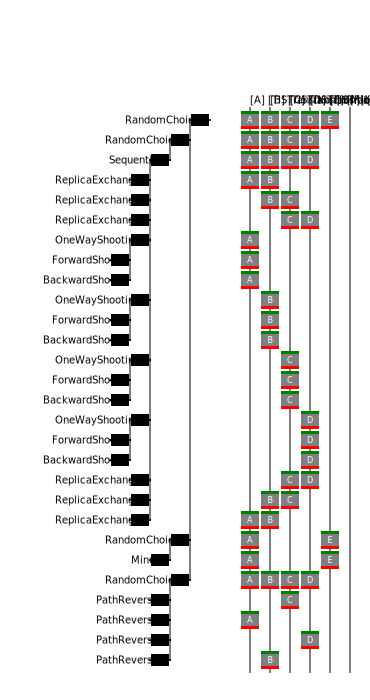

In [8]:
move_vis = ops_vis.MoveTreeBuilder.from_scheme(custom_scheme)
SVG(move_vis.svg())

In [13]:
# output file for use in paper; use other tools to convert SVG=>PDF/PNG
svg_out = open("custom_scheme.svg", 'w')
svg_out.write(move_vis.svg())
svg_out.close()

# Get initial conditions

In [9]:
initial_samples = paths.FullBootstrapping(transition=network.sampling_transitions[0],
                                          snapshot=template,
                                          engine=engine).run()

DONE! Completed Bootstrapping cycle step 40 in ensemble 4/4.


In [10]:
transition = network.sampling_transitions[0]
minus_sample = network.minus_ensembles[0].extend_sample_from_trajectories(
    trajectories=[initial_samples[transition.ensembles[0]].trajectory],
    engine=engine,
    replica=-1
)
initial_samples = initial_samples.apply_samples(minus_sample)

In [11]:
initial_samples.sanity_check()

In [12]:
print "Default Scheme:", default_scheme.initial_conditions_report(initial_samples)
print "Custom Scheme:", custom_scheme.initial_conditions_report(initial_samples)

Default Scheme: No missing ensembles.
No extra ensembles.

Custom Scheme: No missing ensembles.
No extra ensembles.



# Run each of the simulations

In [13]:
n_tries_per_shooting = 10000

In [14]:
# take the number of steps from a single ensemble shooting
n_steps = default_scheme.n_steps_for_trials(
    mover=default_scheme.movers['shooting'][0],
    n_attempts=n_tries_per_shooting
)
n_steps = int(n_steps)+1
print n_steps

77001


In [15]:
default_storage = paths.Storage("default_scheme.nc", "w")

In [16]:
default_calc = paths.PathSampling(
    storage=default_storage,
    sample_set=initial_samples,
    move_scheme=default_scheme
)
default_calc.save_frequency = 100

In [17]:
default_calc.run(n_steps)

Working on Monte Carlo cycle number 77001
Running for 10519 seconds -  7.32 steps per second
Expected time to finish: 0 seconds
DONE! Completed 77001 Monte Carlo cycles.


In [18]:
# in repex_shoot_repex, one move shoots all the ensembles
n_steps = custom_scheme.n_steps_for_trials(
    mover=custom_scheme.movers['repex_shoot_repex'],
    n_attempts=n_tries_per_shooting
)
n_steps = int(n_steps)+1
print n_steps

32001


In [19]:
custom_storage = paths.Storage("custom_scheme.nc", "w")

In [20]:
custom_calc = paths.PathSampling(
    storage=custom_storage,
    sample_set=initial_samples,
    move_scheme=custom_scheme
)
custom_calc.save_frequency = 100

In [21]:
custom_calc.run(n_steps)

Working on Monte Carlo cycle number 32001
Running for 13914 seconds -  2.30 steps per second
Expected time to finish: 0 seconds
DONE! Completed 32001 Monte Carlo cycles.


# Analyze the results

In [22]:
# if loading from stored files (not running the stuff above)
#default_storage = paths.AnalysisStorage("default_scheme.nc")
#custom_storage = paths.AnalysisStorage("custom_scheme.nc")
#default_scheme = default_storage.schemes[0]
#custom_scheme = custom_storage.schemes[0]

## A few checks that we are making a fair comparison

### The scheme should be as expected

Also, the number of path reversal moves and the number of minus moves should be similar in both schemes.

In [23]:
default_scheme.move_summary(default_storage.steps)

repex ran 19.531% (expected 19.48%) of the cycles with acceptance 3171/15039 (21.09%)
shooting ran 51.818% (expected 51.95%) of the cycles with acceptance 27154/39900 (68.06%)
minus ran 2.582% (expected 2.60%) of the cycles with acceptance 1977/1988 (99.45%)
pathreversal ran 26.070% (expected 25.97%) of the cycles with acceptance 17256/20074 (85.96%)


In [24]:
custom_scheme.move_summary(custom_storage.steps)

repex_shoot_repex ran 31.787% (expected 31.25%) of the cycles with acceptance 10118/10172 (99.47%)
minus ran 6.353% (expected 6.25%) of the cycles with acceptance 2023/2033 (99.51%)
pathreversal ran 61.861% (expected 62.50%) of the cycles with acceptance 16641/19796 (84.06%)


### The number of snapshots generated by each should be similar

In [25]:
print len(default_storage.snapshots), len(custom_storage.snapshots)

4087592 4201348


### Check that we have about the same number of shooting moves per ensemble for each scheme

In [26]:
default_scheme.move_summary(default_storage.steps, "shooting")

OneWayShootingMover [TISTransition] 3 ran 12.887% (expected 12.99%) of the cycles with acceptance 6079/9923 (61.26%)
OneWayShootingMover [TISTransition] 0 ran 13.118% (expected 12.99%) of the cycles with acceptance 7817/10101 (77.39%)
OneWayShootingMover [TISTransition] 2 ran 12.866% (expected 12.99%) of the cycles with acceptance 6393/9907 (64.53%)
OneWayShootingMover [TISTransition] 1 ran 12.947% (expected 12.99%) of the cycles with acceptance 6865/9969 (68.86%)


In [27]:
custom_scheme.move_summary(custom_storage.steps, "repex_shoot_repex")

Sequential ran 31.787% (expected 31.25%) of the cycles with acceptance 10118/10172 (99.47%)


## Analyze the output to compare the efficiency

### Count the number of round trips done

In [28]:
default_repx_net = paths.ReplicaNetwork(default_scheme, default_storage.steps)

In [29]:
default_trips = default_repx_net.trips(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [31]:
custom_repx_net = paths.ReplicaNetwork(custom_scheme, custom_storage.steps)

In [32]:
custom_trips = custom_repx_net.trips(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [43]:
print "Number of round trips (default scheme):", len(default_trips['round'])
print "Number of round trips (custom scheme):", len(custom_trips['round'])

Number of round trips (default scheme): 70
Number of round trips (custom scheme): 66


Since the "time" for each round trip is reported as a number of steps, we scale them so that they represent a fraction of the total simulation (making this into a even comparison, since the two simulations require about the same amount of MD.)

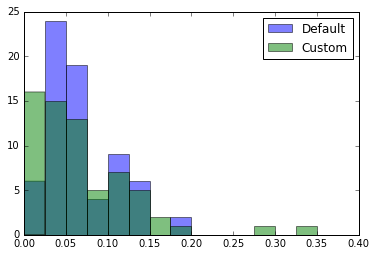

In [47]:
plt.hist(np.array(default_trips['round']) / 77001.0, bins=np.arange(0.0, 0.40, 0.025), color='b', alpha=0.5, label='Default')
plt.hist(np.array(custom_trips['round']) / 32001.0, bins=np.arange(0.0, 0.40, 0.025), color='g', alpha=0.5, label="Custom")
plt.legend();

Although the data is limited, it does appear that the distribution of round trip times is different between the two schemes. However, the total number of round trips is not significantly different.

### Check the replica flow for each scheme

In [35]:
default_flow = default_repx_net.flow_pd(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

In [36]:
custom_flow = custom_repx_net.flow_pd(bottom=network.minus_ensembles[0], top=network.sampling_ensembles[-1])

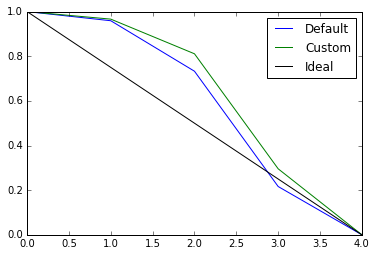

In [45]:
plt.plot(default_flow, 'b', label='Default')
plt.plot(custom_flow, 'g', label='Custom')
perfect_flow = [1.0 - float(i)/(len(default_flow)-1) for i in range(len(default_flow))]
plt.plot(perfect_flow, 'k', label='Ideal')
plt.legend()

The flow is about the same for both schemes; perhaps a little better for the default scheme.